In [33]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *
from shutil import copyfile
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import plotting_params

In [34]:
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_alpha_scale_for_bkg(signal_harmonics=np.arange(0,13,1),signal_strength=np.arange(1e8),fundamental_freq=3):
    gen_alpha_bkg = 13*[1/1e1] # make a small background signal, which is basically unmeasureable (0 does not work for coding reasons)
    #print(len(gen_alpha_bkg),len(signal_harmonics))
    counter=0
    for harmonic in signal_harmonics:
        counter+=1
        #print(harmonic)
        gen_alpha_bkg[int(harmonic/fundamental_freq)]=1/signal_strength[counter-1]
    return gen_alpha_bkg

In [35]:
def mock_injection_signal(alpha_scale,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF"):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    #plt.plot(1*signal_sim[1])
    #plt.ylabel("Force [N]")
    #plt.xlabel("time[s]")
    #plt.show()
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    TF_phases = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]    
    if(phase_shift=="TF"):TF_phase_shift = TF_phases
    elif(phase_shift=="Flip"):TF_phase_shift = [-1*element for element in TF_phases] # this flips
    elif(phase_shift=="Random_TF"):TF_phase_shift = [1*np.random.normal(element,element/20) for element in TF_phases]
    elif(phase_shift=="Random"):TF_phase_shift =  np.random.uniform(-np.pi,np.pi,len(TF_phases))
    else:TF_phase_shift = len(TF_phases)*[0]
    print(TF_phase_shift)
    harmonics = np.arange(3,len(TF_phases)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

    fft_sim = np.fft.rfft(signal_sim[1]) 
    new_fft_sim = fft_sim.copy()
    new_fft_shift_only = fft_sim.copy()
    #new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0]) # not necessary?
    for harmonic in harmonics:
        new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
        new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

    signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
    signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    
    
    # extend to 10s
    z_sig = repeat(signal_sim_shift_scale,10)
    # scale to desired alpha
    z_sig_10 = np.multiply(z_sig,alpha_scale)
    
    #plt.plot(z_sig_10)
    #plt.xlim(0,5000)
    #plt.xlabel("time [s]")
    #plt.ylabel("intensity [bits]")
    #plt.show()
    return z_sig_10,TF_phase_shift,amplitude_scale

In [36]:
def generate_background_signal(background_sim,signal_harmonics,signal_strength,TF_phase_bkg=None):
    if(TF_phase_bkg==None): TF_phase_shift = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
    else:TF_phase_shift = TF_phase_bkg
   # print(TF_phase_shift)

    harmonics = np.arange(3,len(TF_phase_shift)*3+3,3)
    #print(len(TF_phase_shift))

    # possibly add random fluctuations around the normal
    TF_phase_shift_norm = [1*np.random.normal(TF_phase_shift[i],np.abs(TF_phase_shift[i])/20) for i in range(len(TF_phase_shift))]

    alpha_scale_bkg = generate_alpha_scale_for_bkg(signal_harmonics=signal_harmonics,signal_strength=signal_strength)

    TF_amp_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18] # transforming to bits

    amplitude_scale = np.multiply(TF_amp_scale,alpha_scale_bkg)
    fft_sim_bkg = np.fft.rfft(background_sim) 

    new_fft_sim_bkg = fft_sim_bkg.copy()
    #new_fft_sim_bkg[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim_bkg[0]) # not necessary

    for harmonic in harmonics:
        new_fft_sim_bkg[harmonic] = 1/amplitude_scale[harmonic//3-1]*(np.abs(fft_sim_bkg[harmonic])) *np.exp(1j*(np.angle(fft_sim_bkg[harmonic])-TF_phase_shift[harmonic//3-1]))

    signal_sim_bkg =np.fft.irfft(new_fft_sim_bkg) 
    z_bkg = repeat(signal_sim_bkg,10)
    time_rep=np.arange(0,10,1/5000)
    
    return z_bkg

In [121]:
in_dir = r"/data/new_trap_processed/mockfiles/20200320/raw/noise/"
out_dir = r"/data/new_trap_processed/mockfiles/20200320/output/noise/testforalex/1/"

in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)
    in_file_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))  # onlt for debugging, we want the randomness otherwise   



In [122]:
x_sep = 13.9#10.39
height_sep=-15.5#-15.7
stroke=-202.11
frequency=3
lambda_val=10  #20
axis="z"
offset_y=4.9
yuk_or_grav="yuk"
alpha=1
bead_size=7.6
_,background_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)


Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force


In [123]:
z_sig,_,_ = mock_injection_signal(2e1,10)

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]


In [124]:
#signal_strength = [1e3] file 0
#signal_strength=[9e8] file 1
#signal_strength=[9e8]*5 file 2
#signal_strength=[9e8* np.sin(2*np.pi*t+np.pi) for t in np.arange(0,1.0001,1/1000)] file 3
#signal_strength=[8e8* np.sin(2*np.pi*t+np.pi) for t in np.arange(0,1.0001,1/1000)] file 4
# signal_strength = [-1e9*1*t+4e8 for t in np.arange(0,1.0001,1/1000)] file 5
#signal_strength = [-9e8*1*t+4.5e8 for t in np.arange(0,1.0001,1/1000)] file 6
#signal_strength = [2e9*(sigmoid(t)-0.5) for t in np.arange(-10,10.005,1/50)] file 7
#signal_strength = [4e9*(sigmoid(t)-0.5) for t in np.arange(-10,10.005,1/50)] #file 8

#signal_strength = [1e3] #stbin2 0 + 1
signal_strength=[9e8]# stbin file 2



In [125]:
max_files=1001
i=0
direction="pull"
out_dirs=  out_dir
try: os.makedirs(out_dirs)
except: print("Did not create %s. It may exist or you do not have perimissions." %out_dir) 

for file_path in tqdm(in_file_paths):
    i+=1
    if(i<(max_files+1)):
        #if (i % 10==0):print("%f percent" %(i/max_file*100))
        with h5py.File(file_path, 'r') as f_in:
            quad_data_in = np.array(f_in['quad_data'])
            data_in = quad_data_in.reshape(-1,12).T[9]
            #plt.plot(np.array(data_in))
            random_uni =np.random.uniform(-0.5,0.5,len(data_in)) # make a list of random numbers between -0.5 and 0.5
            new_data_uni = data_in + random_uni# add the
            z_bkg_pull = 0 #generate_background_signal(background_sim,signal_harmonics=[18],signal_strength=signal_strength)
            z_bkg_push = generate_background_signal(background_sim,signal_harmonics=[18],signal_strength=signal_strength)
            z_bkg = 0#generate_background_signal(background_sim,signal_harmonics=[3],signal_strength=signal_strength)
            #print(signal_strength[i])
            #print(signal_strength)
            final_signal = z_sig + z_bkg + z_bkg_pull - z_bkg_push   
            if(direction=="push"): z_sn = np.subtract(np.array(new_data_uni),np.array(final_signal))
            elif(direction=="pull"): z_sn = np.add(np.array(new_data_uni),np.array(final_signal))
            else: print("Force has to go either way")
            z_sn_round = [round(element) for element in z_sn] # round to half even
            quad_data_in.reshape(-1,12).T[9] = z_sn_round
            f_in.close()
            #plt.plot(np.array(z_sn),color="black")
        out_path = out_dirs + "Noise_batch_%d.h5" %(i-1)
        copyfile(src=file_path, dst=out_path)
        with h5py.File(out_path, 'r+') as f_out:
            del f_out['quad_data']
            f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
            f_out.close()


100%|██████████| 1000/1000 [01:29<00:00, 11.32it/s]


In [126]:
in_dir=r"/data/new_trap_processed/mockfiles/20200320/output/noise/testforalex/1/"
out_dir=r"/data/new_trap_processed/mockfiles/20200320/output/noise/StBiN2/0/"

signal_paths = []
for signal_path in glob.iglob(out_dir+"*.h5"):
    signal_paths.append(signal_path)
    signal_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))  # onlt for debugging, we want the randomness otherwise   

    
in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)
    in_file_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))  # onlt for debugging, we want the randomness otherwise   



In [251]:
i=0
sumsum=0
sum_raw=0
sum_dat=0

max_files=2
for file_path in tqdm(in_file_paths):
    i+=1
    if(i<max_files):
        with h5py.File(file_path, 'r') as f_raw:
            quad_data_raw = np.array(f_raw['quad_data'])
            data_raw = quad_data_raw.reshape(-1,12).T[9]
            f_raw.close()
        with h5py.File(signal_paths[i-1], 'r') as f_dat:
            quad_data_dat = np.array(f_dat['quad_data'])
            data_dat = quad_data_dat.reshape(-1,12).T[9]
            f_dat.close() 
        
        sum_raw+=(data_raw)
        sum_dat+=(data_dat)
        sumsum+=(data_dat-data_raw)
        #plt.plot(data_dat-data_raw)
        #plt.plot(data_raw,alpha=0.5)
        #plt.xlim(0,5000)
        #plt.xlabel("time")
        #plt.ylabel("intensity[bits]")
        #plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 8152.62it/s]


In [252]:
fft_sig2 = np.fft.rfft(sum_raw)
fft_noise2 = np.fft.rfft(sum_dat)

(0.0, 5000.0)

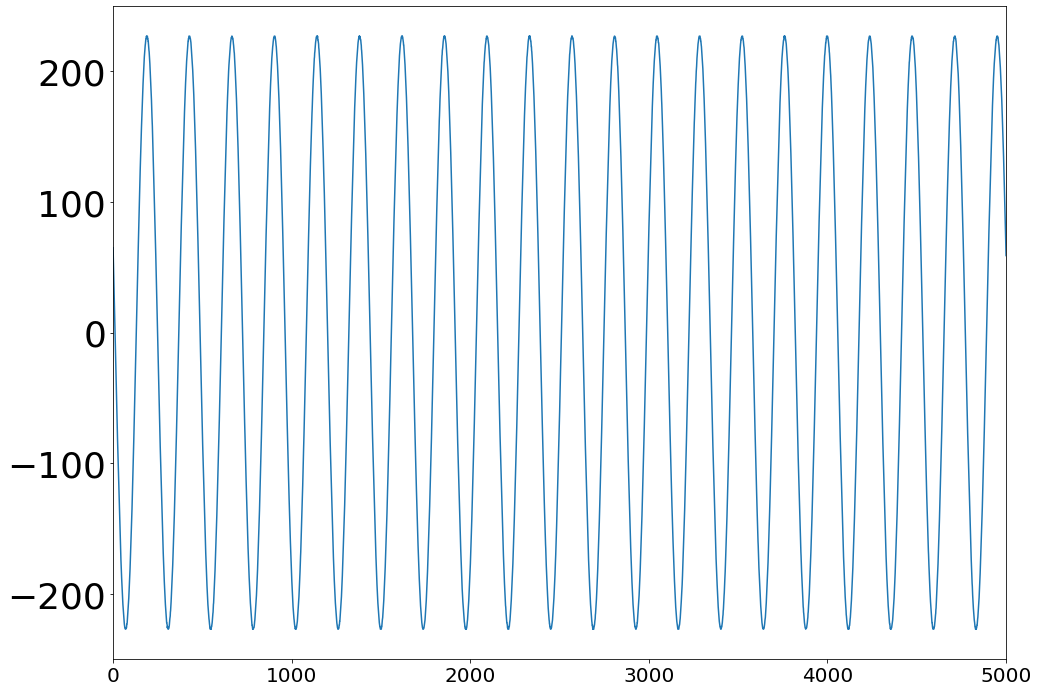

In [253]:
plt.plot(sumsum)
plt.xlim(0,5000)


In [254]:
file_path = "/data/new_trap/20201211/Bead1/InitialTest/Data19.h5"
with h5py.File(file_path, 'r') as f_in:
    quad_data_in = np.array(f_in['quad_data'])
    data_in_srs = quad_data_in.reshape(-1,12).T[9]

In [255]:
fft_srs = np.fft.rfft(data_in_srs)

(0.0, 50.0)

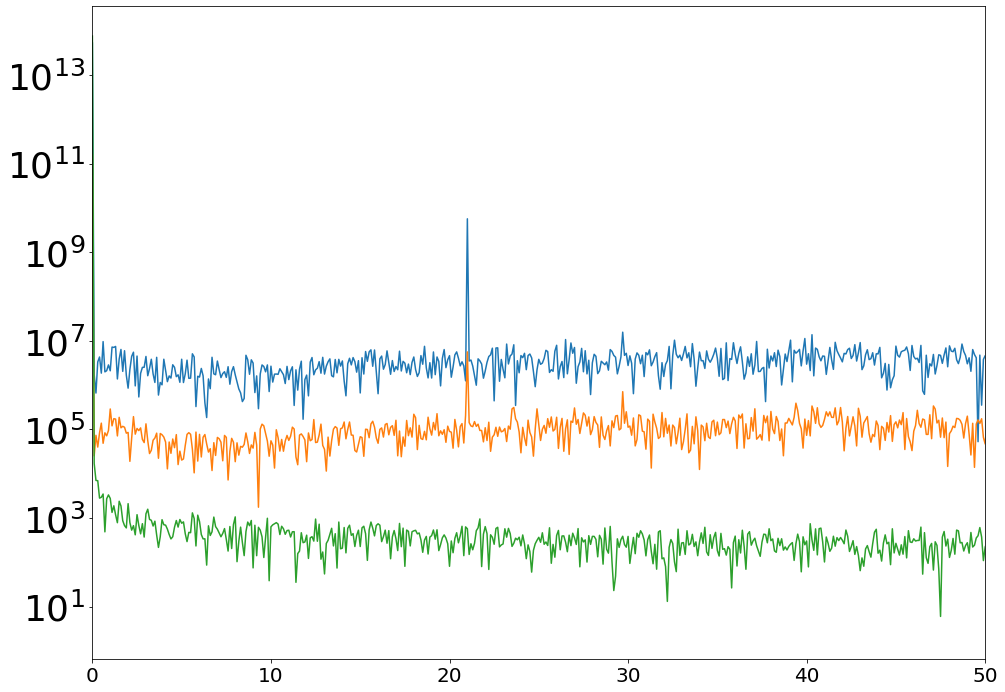

In [256]:
x=np.arange(0,2500.1,0.1)
plt.plot(x,np.abs(fft_sig))
plt.plot(x,np.abs(fft_sig2))
plt.plot(x,np.abs(fft_srs))
#plt.plot(x,np.abs(fft_noise2))
#plt.plot(x,np.abs(fft_noise))
plt.yscale("log")
plt.xlim(0,50)

(array([  8.01000000e+02,   2.22100000e+03,   3.30700000e+03,
          3.46000000e+03,   3.48900000e+03,   3.01400000e+03,
          2.32700000e+03,   1.70000000e+03,   1.21800000e+03,
          8.10000000e+02,   5.84000000e+02,   3.96000000e+02,
          2.91000000e+02,   2.62000000e+02,   1.90000000e+02,
          1.51000000e+02,   1.26000000e+02,   1.00000000e+02,
          6.80000000e+01,   8.60000000e+01,   6.00000000e+01,
          4.30000000e+01,   4.90000000e+01,   3.30000000e+01,
          3.40000000e+01,   2.60000000e+01,   3.20000000e+01,
          1.90000000e+01,   1.80000000e+01,   1.30000000e+01,
          9.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          8.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

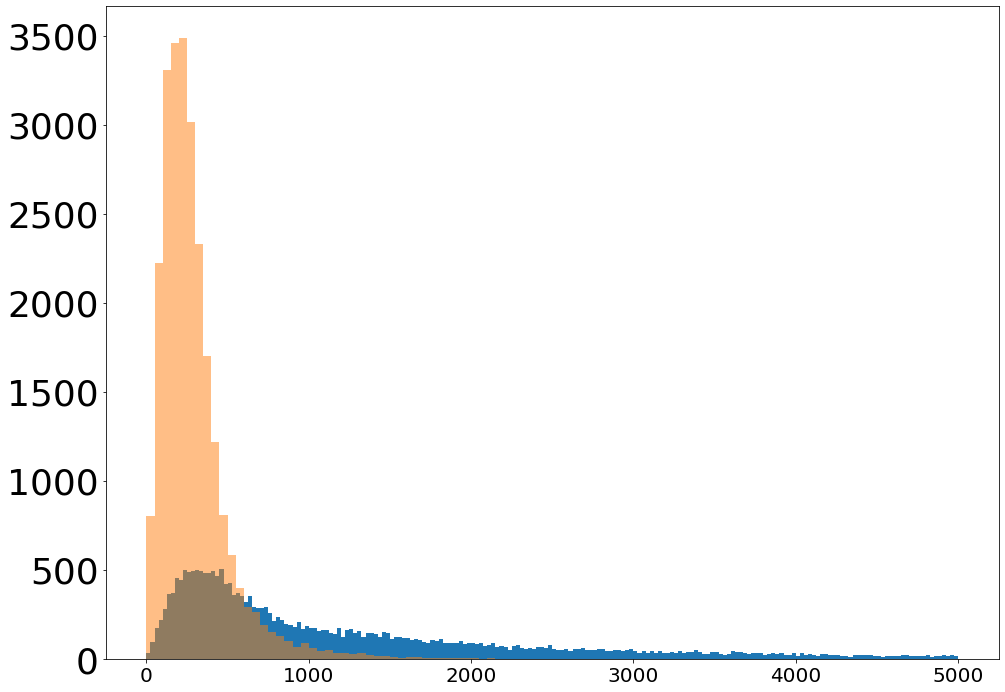

In [259]:
plt.hist(np.abs(fft_sig2)/np.sqrt(10000),range=(0,5e3),bins=200)
#plt.hist(np.abs(fft_sig)/np.sqrt(1000),range=(0,5e3),bins=200)
plt.hist(np.abs(fft_srs)/np.sqrt(1),range=(0,5e3),bins=100,alpha=0.5)


In [194]:
print(np.abs(fft_sig[210]))
print(np.abs(fft_sig2[210]))

5673355328.86
57021462.7553


In [195]:
print(np.mean(np.abs(fft_sig)))
print(np.mean(np.abs(fft_sig2)))


2111355779.67
64778944.9339


In [196]:
print(np.abs(fft_sig[210])/np.abs(fft_sig2[210]))

99.4950857926


In [197]:
print(np.abs(fft_sig[340])/np.abs(fft_sig2[340]))

22.8280064528
